In [1]:
%load_ext autoreload
%autoreload 2
import sys
paths = ['../models', '../dataset', '../util']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

import json
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib

from scipy.misc import imread

import dataset
from data_generators import get_data
from bounding_boxes import get_bounding_boxes, largest_bbox_per_image

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


In [2]:
DATA_FOLDER = '/media/joris/Scrub/Data'
#bboxes = get_bounding_boxes('/media/joris/Scrub/Data/bounding_boxes')
#bboxes = largest_bbox_per_image(bboxes)
bboxes = joblib.load('../data/fcn_bboxes.pkl')
train_data = dataset.train
val_data = dataset.validation
labels = dataset.labels

In [3]:
train_data = train_data[train_data.filename.isin(bboxes.keys())]
val_data = val_data[val_data.filename.isin(bboxes.keys())]
test_files = sorted([os.path.basename(p) for p in glob.glob(os.path.join(DATA_FOLDER, 'test/ALB/*.jpg'))])
test_data = pd.DataFrame({'filename':test_files, 'label': ['ALB']*len(test_files)})

In [82]:
model = Sequential()
model.add(BatchNormalization(input_shape=[3, 256, 256], axis=1))
model.add(Convolution2D(16, 3, 3, border_mode='same', input_shape=[3, 256, 256], 
                        activation='relu'))
model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy', 'categorical_crossentropy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNorma (None, 3, 256, 256)   12          batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_101 (Convolution2D (None, 16, 256, 256)  448         batchnormalization_5[0][0]       
____________________________________________________________________________________________________
convolution2d_102 (Convolution2D (None, 16, 256, 256)  2320        convolution2d_101[0][0]          
____________________________________________________________________________________________________
maxpooling2d_41 (MaxPooling2D)   (None, 16, 128, 128)  0           convolution2d_102[0][0]          
___________________________________________________________________________________________

In [13]:
train_gen = get_data(train_data, os.path.join(DATA_FOLDER, 'train'), augmentation=True,
                     bboxes=bboxes, flip=True, shift_x=5, shift_y=5, rot_range=10, 
                     elastic_trans=False)
val_gen = get_data(val_data, os.path.join(DATA_FOLDER, 'train'), bboxes=bboxes,
                   augmentation=False, shuffle=False)

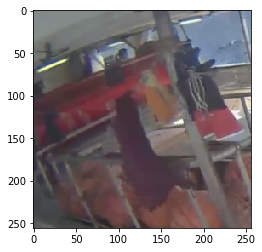

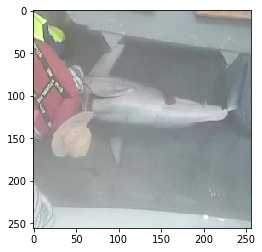

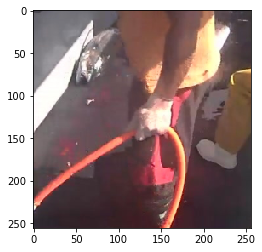

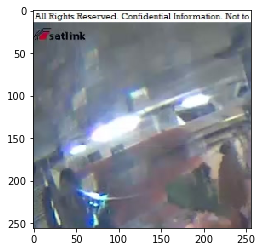

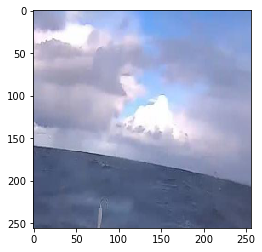

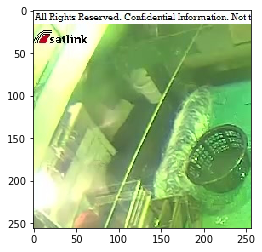

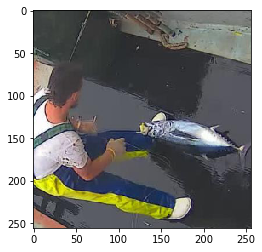

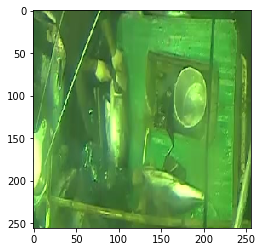

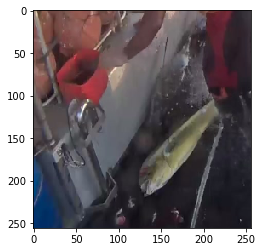

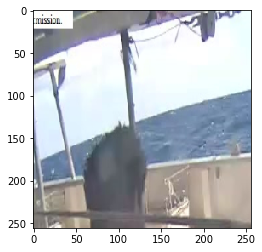

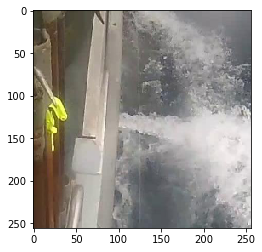

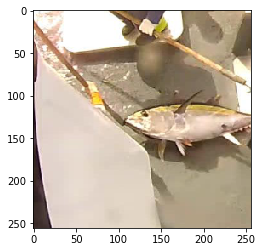

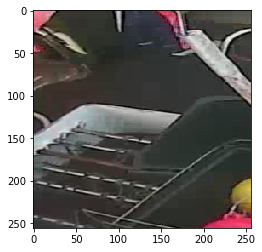

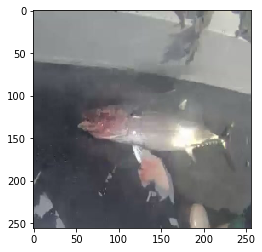

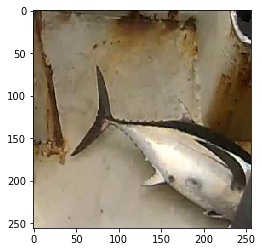

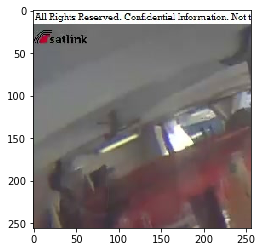

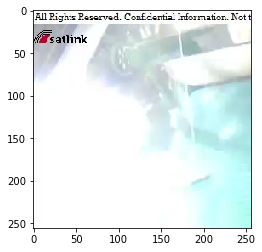

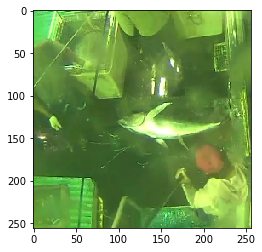

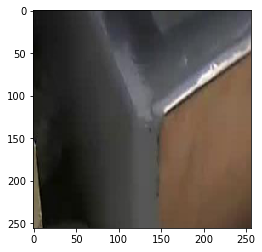

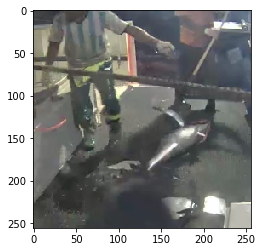

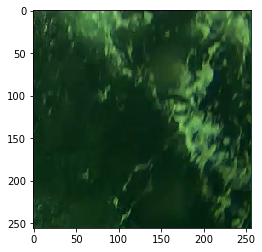

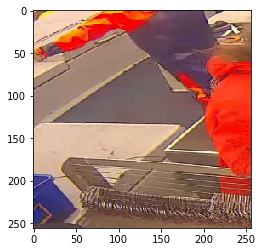

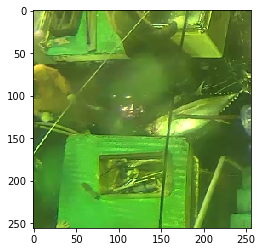

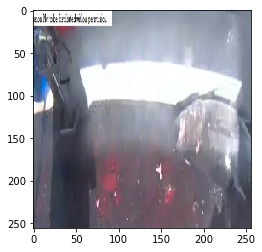

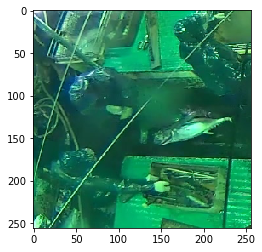

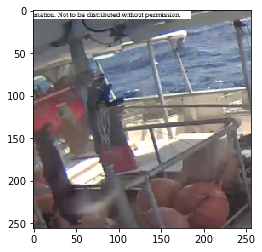

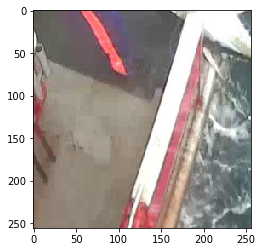

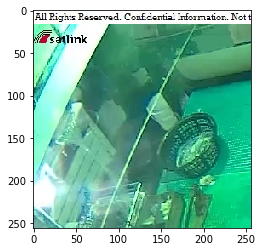

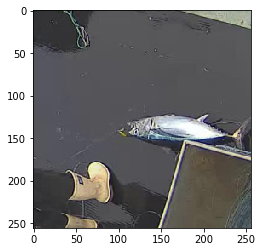

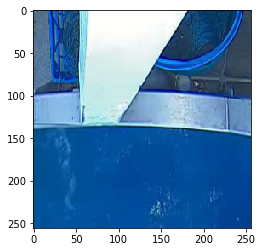

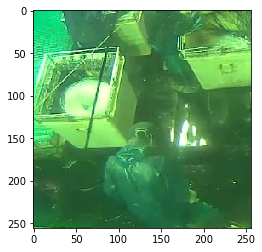

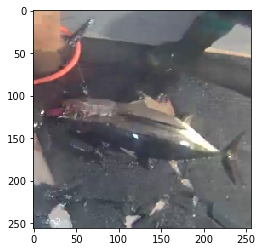

In [8]:
batch = next(test_gen)
for img in batch:
    plt.imshow(img.transpose(1, 2, 0) + 0.5)
    plt.show()

In [ ]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint(filepath='/media/joris/Scrub/Models/fcn_crop/model.{epoch:02d}-{val_loss}.hdf5',
                             verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(train_data),
                    nb_epoch=500,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(val_data),
                    pickle_safe=True, nb_worker=3)

Epoch 1/500
3040/3021 [==============================] - 39s - loss: 1.6850 - acc: 0.4408 - categorical_crossentropy: 1.6850 - val_loss: 1.6740 - val_acc: 0.4492 - val_categorical_crossentropy: 1.6740
Epoch 2/500
3040/3021 [==============================] - 38s - loss: 1.4794 - acc: 0.4928 - categorical_crossentropy: 1.4794 - val_loss: 1.4910 - val_acc: 0.4648 - val_categorical_crossentropy: 1.4910
Epoch 3/500
3040/3021 [==============================] - 38s - loss: 1.3541 - acc: 0.5141 - categorical_crossentropy: 1.3541 - val_loss: 1.4384 - val_acc: 0.4961 - val_categorical_crossentropy: 1.4384
Epoch 4/500
3040/3021 [==============================] - 38s - loss: 1.2551 - acc: 0.5556 - categorical_crossentropy: 1.2551 - val_loss: 1.2752 - val_acc: 0.5430 - val_categorical_crossentropy: 1.2752
Epoch 5/500
3040/3021 [==============================] - 38s - loss: 1.1180 - acc: 0.6102 - categorical_crossentropy: 1.1180 - val_loss: 1.2034 - val_acc: 0.6016 - val_categorical_crossentropy: 1.

In [11]:
model = load_model('/media/joris/Scrub/Models/fcn_crop/model.19-0.585225485265.hdf5')

In [15]:
def remove_labels(gen):
    for x, _ in gen:
        yield x
test_gen = get_data(test_data, os.path.join(DATA_FOLDER, 'test'), bboxes=bboxes,
                   augmentation=False, shuffle=False)
test_gen = remove_labels(test_gen)

In [16]:
preds = model.predict_generator(test_gen, val_samples=1024)[:1000]

In [21]:
preds = np.clip(preds, 0.02, 0.98)

In [22]:
with open('sub.csv', 'w') as sub_file:
    sub_file.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for img, pred in zip(test_files, preds):
        csv = '%s,%s\n' % (img, ','.join([str(f) for f in pred]))
        sub_file.write(csv)